In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Extract the uploaded zip file
zip_path = '/content/drive/MyDrive/TeaLeaftNet/tea_dataset.zip'
extract_path = '/content/TeaLeaftNet_extracted'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted successfully to {extract_path}")

Dataset extracted successfully to /content/TeaLeaftNet_extracted


In [ ]:
!ls -F '/content/drive/MyDrive/TeaLeaftNet/'

tea_dataset.zip


In [ ]:
import os

# List contents of MyDrive to verify the path of TeaLeaftNet.zip
!ls -F '/content/drive/MyDrive/'

'Colab Notebooks'/
 reuters_model.h5
 Screenshot_2026-01-28-18-30-01-468_com.mi.globalbrowser.jpg
 TeaLeaftNet/


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

# 1. Define Parameters
# We resize images to 224x224 as required by the assignment
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
DATA_DIR = '/content/TeaLeaftNet_extracted/tea_dataset' # Corrected path to the actual dataset classes

print("--- Loading and Splitting Dataset ---")
# 2. Load Training Data (80% split)
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# 3. Load Testing/Validation Data (20% split)
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# 4. Verify Classes and Balance
class_names = train_ds.class_names
print(f"\nClasses found: {class_names}")

print("\n--- Verifying Dataset Balance ---")
for class_name in class_names:
    class_path = os.path.join(DATA_DIR, class_name)
    count = len(os.listdir(class_path))
    print(f"{class_name}: {count} images")

# 5. Mandatory Preprocessing: Normalization (Scale pixels to 0-1)
print("\n--- Applying Normalization ---")
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Optimize data loading for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Preprocessing complete! Images are resized, converted to tensors, and normalized.")

--- Loading and Splitting Dataset ---
Found 885 files belonging to 8 classes.
Using 708 files for training.
Found 885 files belonging to 8 classes.
Using 177 files for validation.

Classes found: ['Algal_Leaf', 'Anthracnose', 'Bird_Eye_Spot', 'Brown_Blight', 'Gray_Light', 'Healthy', 'Red_Leaf_Spot', 'White_Spot']

--- Verifying Dataset Balance ---
Algal_Leaf: 113 images
Anthracnose: 100 images
Bird_Eye_Spot: 100 images
Brown_Blight: 113 images
Gray_Light: 100 images
Healthy: 74 images
Red_Leaf_Spot: 143 images
White_Spot: 142 images

--- Applying Normalization ---
Preprocessing complete! Images are resized, converted to tensors, and normalized.


--- Building the CNN Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,272 (24.59 MB)

 Trainable params: 6,447,272 (24.59 MB)

 Non-trainable params: 0 (0.00 B)


--- Training the Model (10 Epochs) ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.1944 - loss: 2.7628 - val_accuracy: 0.2881 - val_loss: 1.6166
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3773 - loss: 1.3836 - val_accuracy: 0.4859 - val_loss: 1.0413
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5247 - loss: 1.0173 - val_accuracy: 0.4972 - val_loss: 1.0436
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6699 - loss: 0.7878 - val_accuracy: 0.6554 - val_loss: 0.9088
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7753 - loss: 0.6029 - val_accuracy: 0.5650 - val_loss: 1.2121
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7576 - loss: 0.5993 - val_accuracy: 0.7345 - val_loss: 0.7616
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8409 - loss: 0.4118 - val_accuracy: 0.7119 - val_loss: 0.9770
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8178 - loss: 0

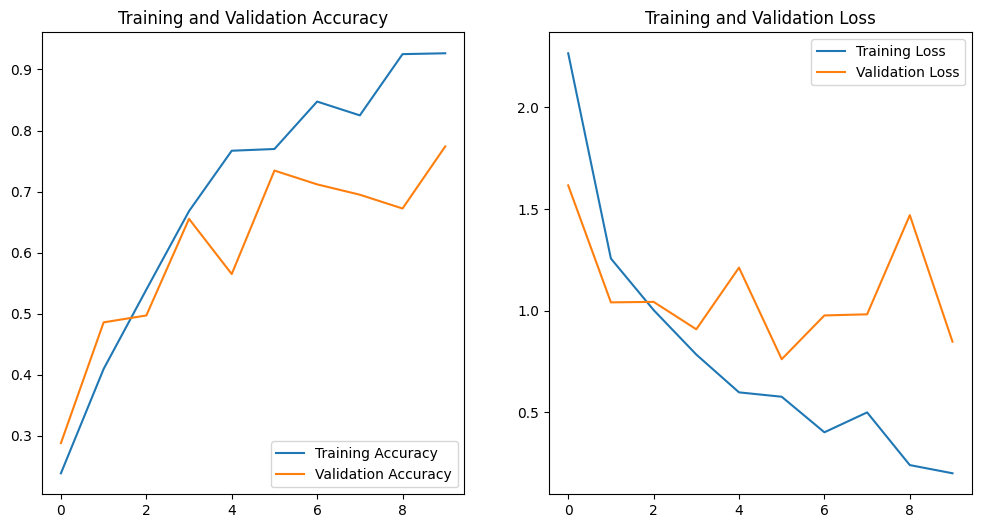


--- Evaluating Model on Test Data ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.7656 - loss: 0.8417
Final Validation Accuracy: 77.40%

Generating Confusion Matrix...


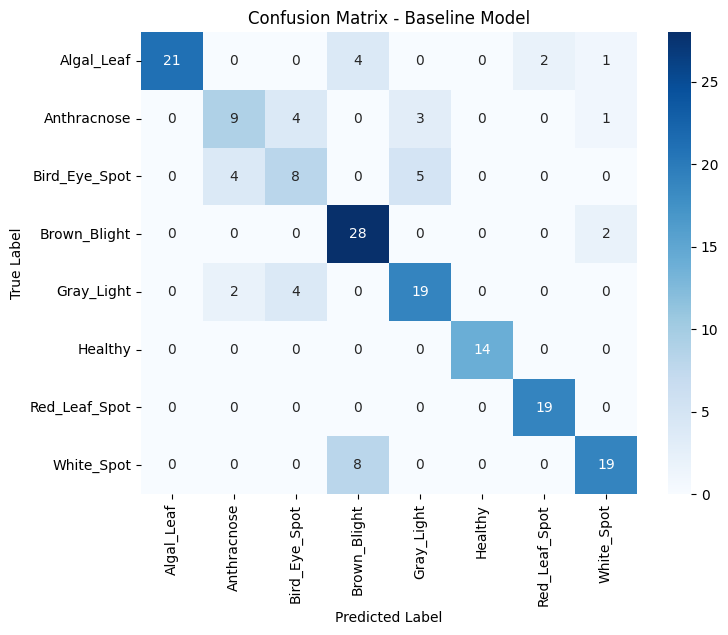


--- Displaying Sample Predictions ---


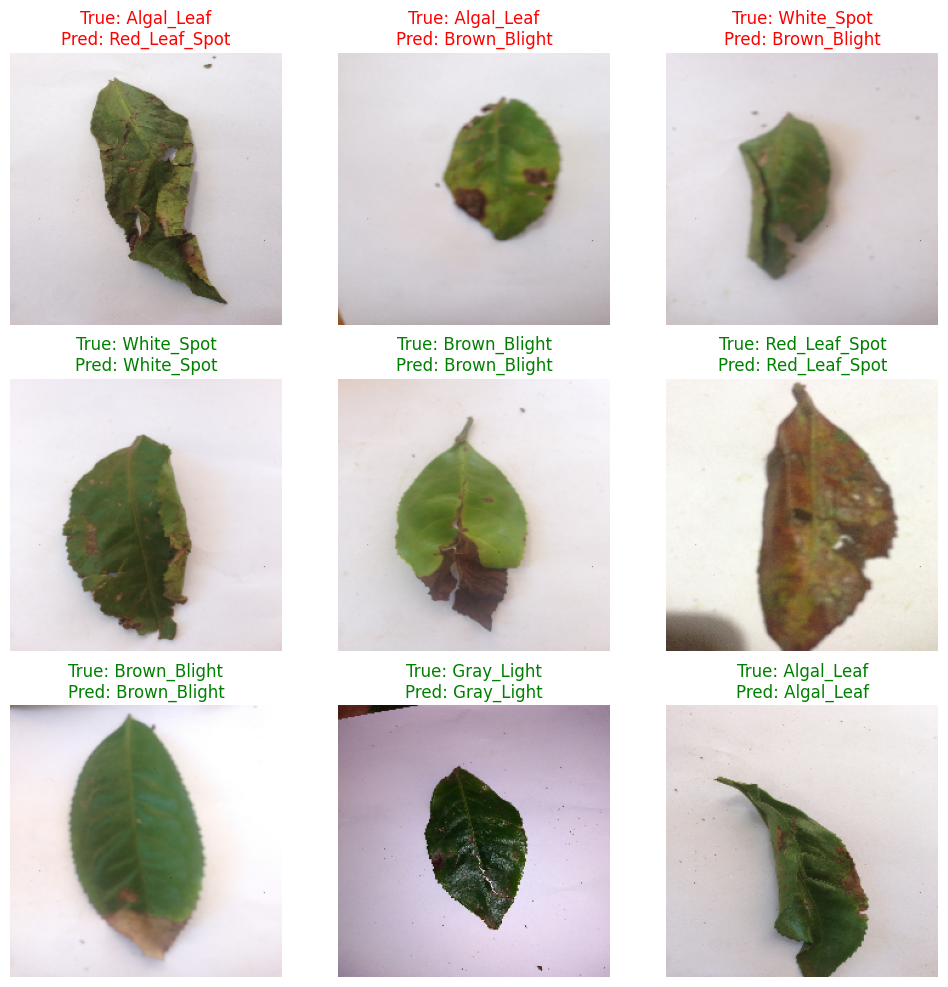


Model successfully saved to: /content/tealeaftnet_baseline.h5


In [20]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Define the Baseline CNN Architecture (Option A)
print("--- Building the CNN Model ---")
num_classes = len(class_names)

model = tf.keras.models.Sequential([
  layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

# 2. Train the Model
print("\n--- Training the Model (10 Epochs) ---")
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# 3. Plot Training & Validation Curves
print("\n--- Generating Performance Curves ---")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 4. Evaluate and Generate Confusion Matrix
print("\n--- Evaluating Model on Test Data ---")
loss, accuracy = model.evaluate(val_ds)
print(f"Final Validation Accuracy: {accuracy*100:.2f}%")

print("\nGenerating Confusion Matrix...")
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Baseline Model')
plt.show()

# 5. Display Sample Predictions
print("\n--- Displaying Sample Predictions ---")
plt.figure(figsize=(12, 12))
for images, labels in val_ds.take(1):
    predictions = model.predict(images, verbose=0)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Scale images back to 0-255 for proper display
        plt.imshow((images[i].numpy() * 255).astype("uint8"))

        true_label = class_names[labels[i]]
        pred_label = class_names[np.argmax(predictions[i])]

        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
plt.show()

# 6. Save the Model
model_save_path = '/content/tealeaftnet_baseline.h5'
model.save(model_save_path)
print(f"\nModel successfully saved to: {model_save_path}")

In [ ]:
!ls -F '/content/TeaLeaftNet_extracted/tea_dataset'

Algal_Leaf/   Bird_Eye_Spot/  Gray_Light/  Red_Leaf_Spot/
Anthracnose/  Brown_Blight/   Healthy/	   White_Spot/
